# Importing packages and reading in data

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler

train_tgt = pd.read_csv("Data/Train_data_tgt.csv") 
train_tgt = train_tgt.drop(columns = ['Unnamed: 0'])
test_tgt = pd.read_csv("Data/Test_data_tgt.csv")
test_tgt = test_tgt.drop(columns = ['Unnamed: 0'])
train_sep = pd.read_csv("Data/Train_data_sep.csv")
train_sep = train_sep.drop(columns = ['Unnamed: 0'])
test_sep = pd.read_csv("Data/Test_data_sep.csv")
test_sep = test_sep.drop(columns = ['Unnamed: 0'])
train_OG = pd.read_csv("Data/train_OG.csv")
train_OG = train_OG.drop(columns = ['Unnamed: 0'])
test_OG = pd.read_csv("Data/test_OG.csv")
test_OG = test_OG.drop(columns = ['Unnamed: 0'])


# Class imbalance functions

In [4]:
def random_undersample(train_data):
    rus = RandomUnderSampler()
    X = train_data.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"])
    Y = train_data['label'] 
    X_resampled, y_resampled = rus.fit_resample(X, Y)
    output = pd.concat([X_resampled,y_resampled],axis = 1) 
    return output

def GANsampling(train_data,no_of_samples = 50000):
    data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=data)
    metadata.update_column("label",sdtype="categorical")
    CTGAN = CTGANSynthesizer(
        metadata, 
        enforce_rounding=False,
        epochs=50,
        verbose=False
    )
    CTGAN.fit(data)
    CT_samples = CTGAN.sample(num_rows=no_of_samples)
    New_positive = CT_samples[CT_samples["label"] == 1]
    output = pd.concat([data,New_positive],axis = 0, ignore_index = True) 
    return output

def adasyn_sample(train):
    X = train.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"])
    y = train['label']
    adasyn_model = ADASYN(sampling_strategy='auto', random_state=42)
    X_adasyn_sample, y_adasyn_sample = adasyn_model.fit_resample(X, y)
    output = pd.concat([X_adasyn_sample, y_adasyn_sample], axis=1)
    return output

# Principal Components with mean and std together

### Random Undersample

In [3]:
new_train_data = random_undersample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


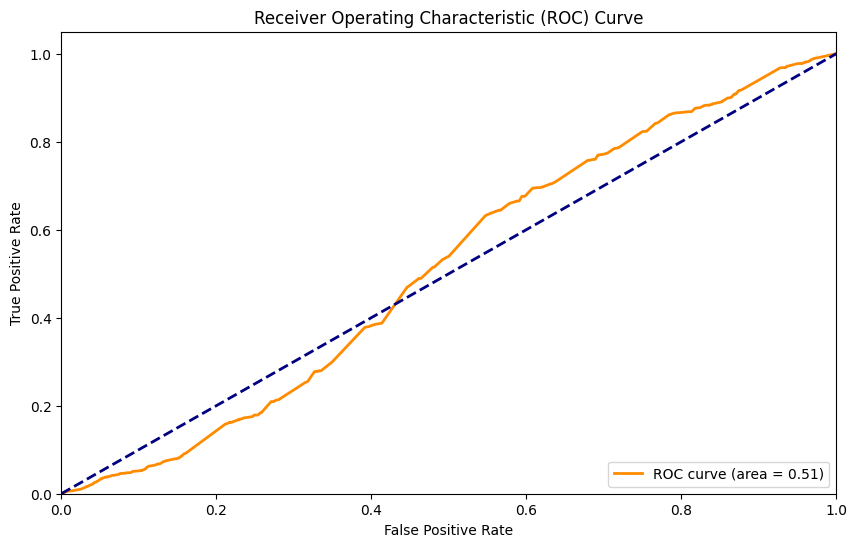

In [4]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

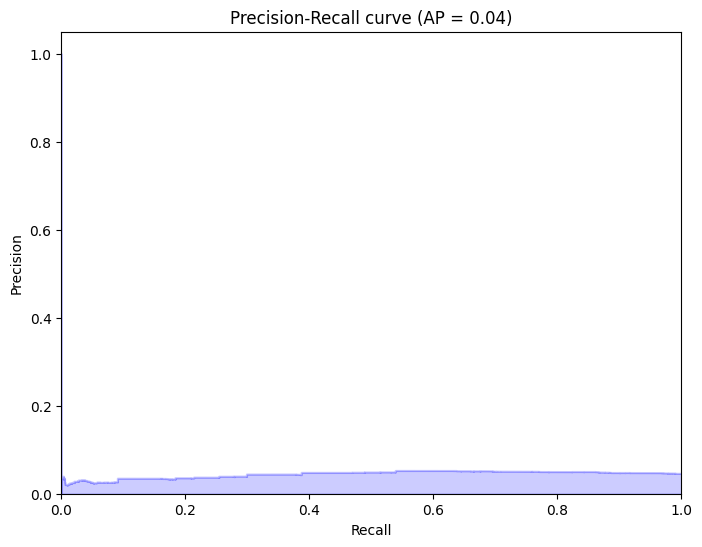

In [5]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [30]:
new_train_data = GANsampling(train_tgt,no_of_samples= 50000)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  'strategy.', FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\rdt\transformers\base.py:135: FutureWarning: Future versions of RDT will not support the 'model_missing_v

KeyboardInterrupt: 

### Adasyn

In [6]:
new_train_data = adasyn_sample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


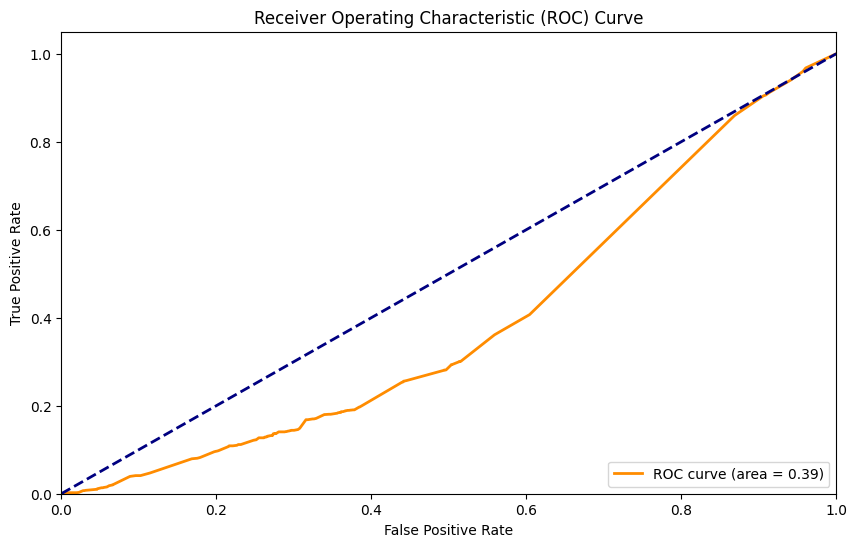

In [7]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

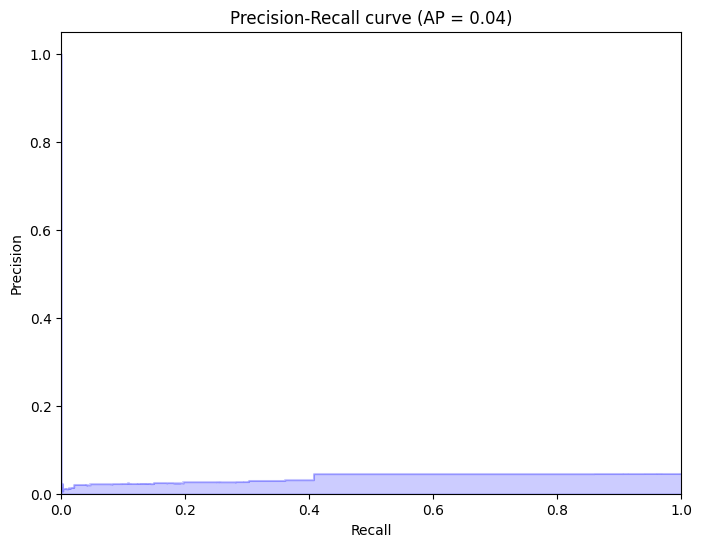

In [8]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Principal Components with mean and std separate

### Random Undersample

In [10]:
new_train_data = random_undersample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:36:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


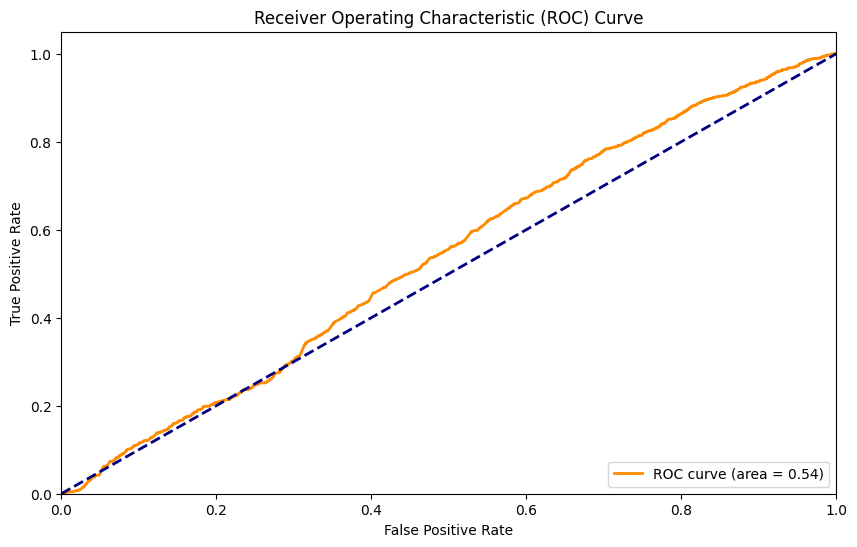

In [11]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

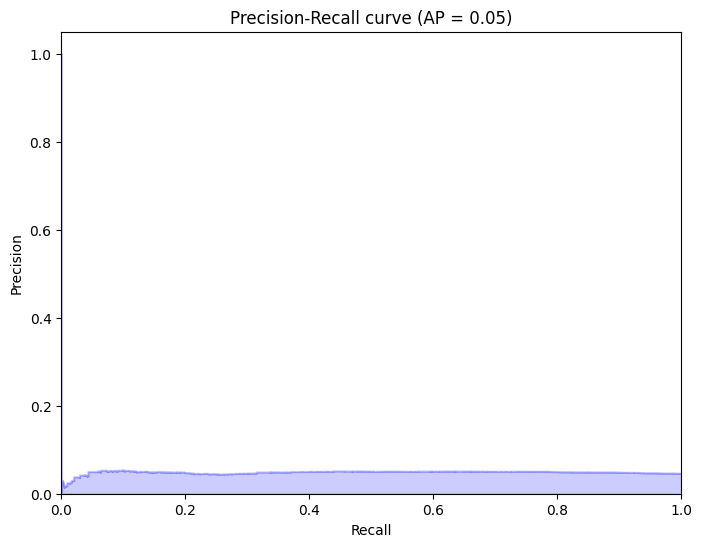

In [12]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [ ]:
new_train_data = GANsampling(train_sep,no_of_samples = 50000)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

### Adasyn

In [13]:
new_train_data = adasyn_sample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


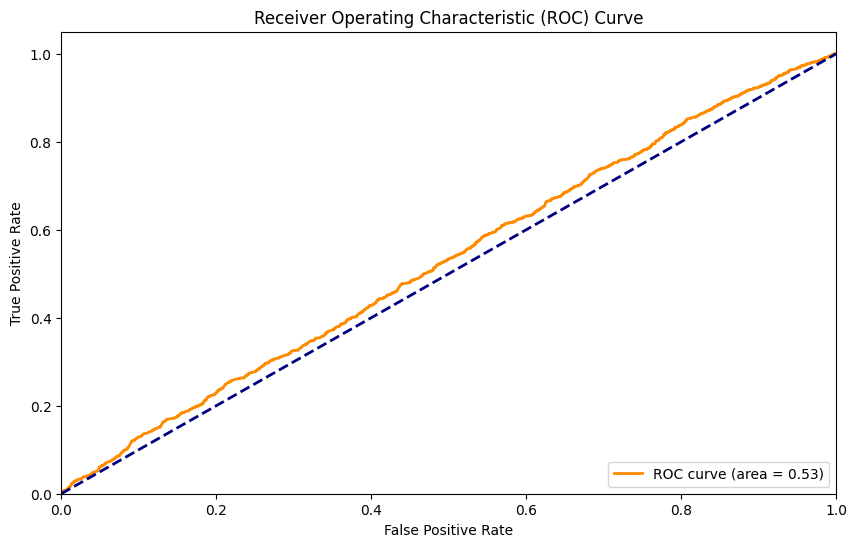

In [14]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

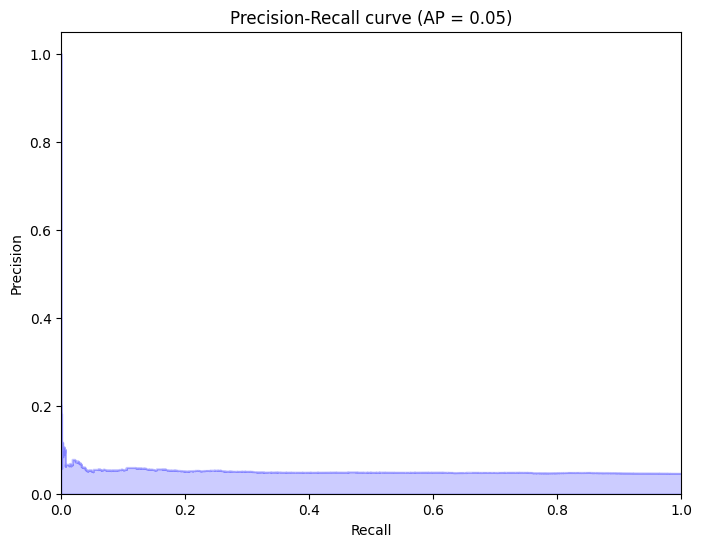

In [15]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# No PCA

## Random Undersample

In [6]:
new_train_data = random_undersample(train_OG)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_OG.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_OG['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


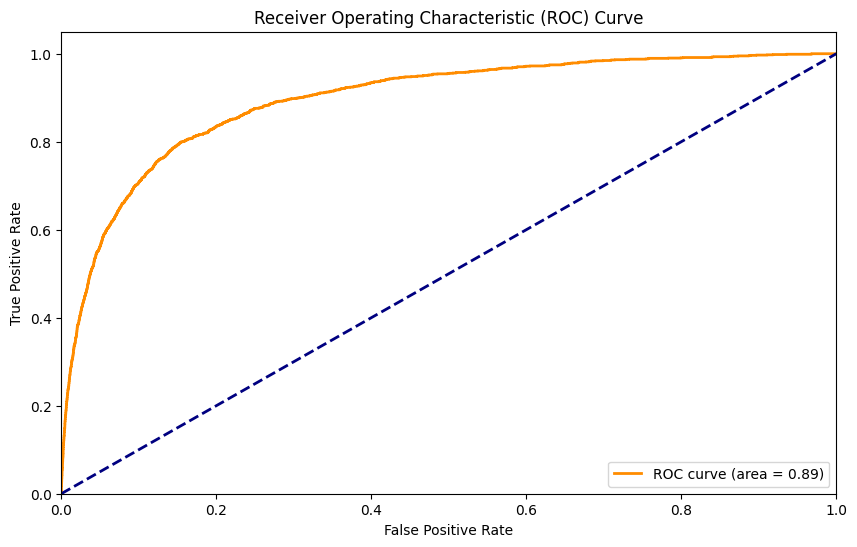

In [7]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

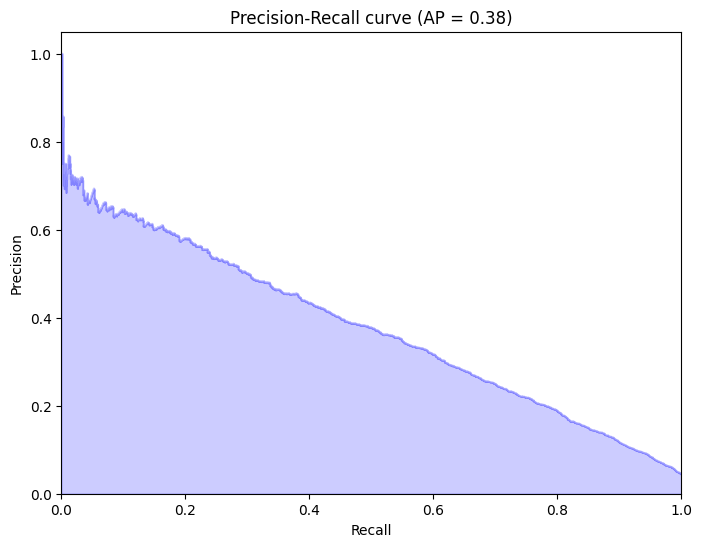

In [8]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

## Adasyn

In [9]:
new_train_data = adasyn_sample(train_OG)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_OG.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_OG['label']

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,            
    max_depth=3,                
    learning_rate=0.1,          
    subsample=0.8,             
    colsample_bytree=0.8,       
)

model.fit(X_train, Y_train)

Y_pred = model.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


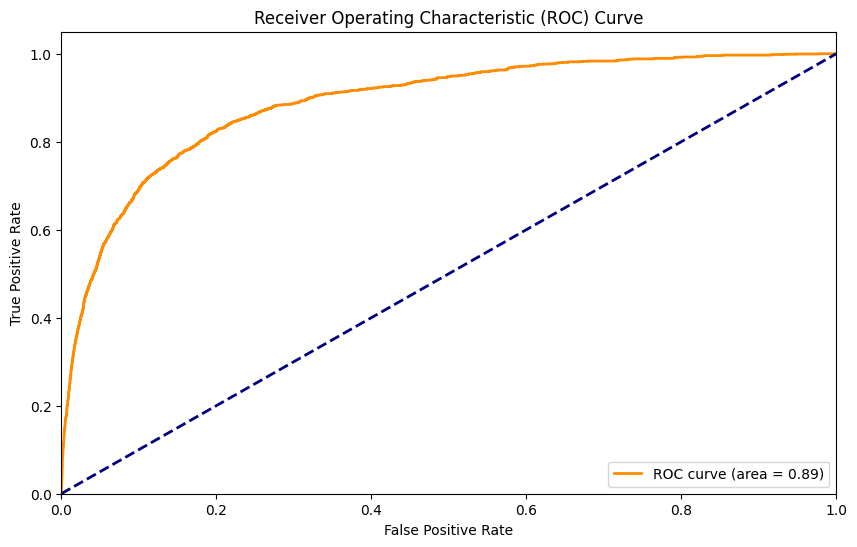

In [11]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

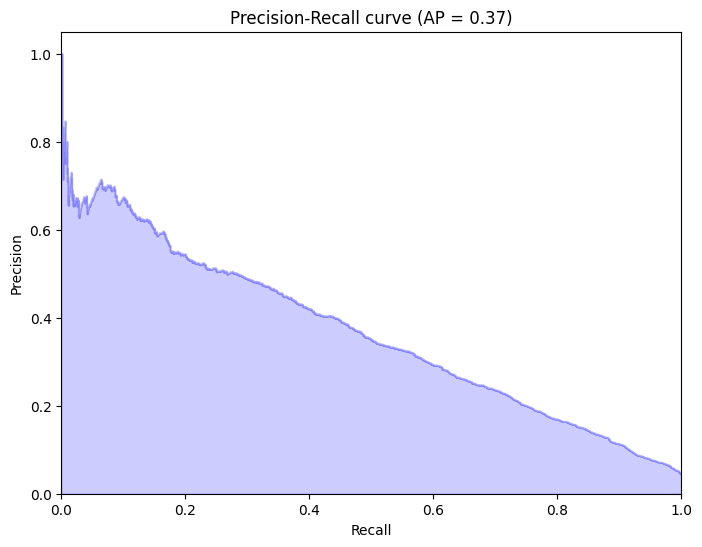

In [12]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()